In [41]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from stargazer.stargazer import Stargazer

sns.set_context("paper", font_scale=1.6)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
        "figure.facecolor": "#FAFAFA",
    },
)

# Import Data

In [42]:
%%time
data_df = pd.read_parquet('../data/processed/sp500_returns.parquet')
data_daily_df = pd.read_parquet('../data/processed/sp500_returns_daily.parquet')

CPU times: user 5.94 s, sys: 19.1 s, total: 25.1 s
Wall time: 16.4 s


In [43]:
%%time
data_mcap_df = pd.read_csv('../data/wrds/market_cap.csv')

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 76 ms


# Clean Data

In [44]:
# Market cap data
data_mcap_df['year'] = data_mcap_df['fyear']
data_mcap_df['ticker'] = data_mcap_df['tic']
data_mcap_df = data_mcap_df[['year', 'ticker', 'mkvalt']].dropna()
data_mcap_df['year'] = data_mcap_df['year'].astype(int)
data_mcap_df.sample(5)

,year,ticker,mkvalt
656,2015,CAG,20019.5705
2414,2010,TER,2555.7714
51,2011,ALK,2663.8178
4113,2012,CPRT,2955.6014
2689,2012,WY,15089.3733


In [45]:
data_har_df = (
    data_df.drop(["price", "log_price"], axis=1).groupby(["ticker", "date"]).sum().reset_index()
)


0        0.000670
1        0.000247
2        0.000171
3        0.000219
4        0.000204
           ...   
95049    0.000087
95050    0.000321
95051    0.000268
95052    0.000235
95053         NaN
Name: return_p2, Length: 95054, dtype: float64

In [49]:
%%time
data_har_df = (
    data_df.drop(["price", "log_price"], axis=1).groupby(["ticker", "date"]).sum().reset_index()
)

CPU times: user 2.52 s, sys: 6.36 s, total: 8.88 s
Wall time: 8.91 s


In [87]:
# Realized Vol
data_har_df["rv_lead"] = data_har_df.groupby('ticker')["return_p2"].shift(-1)

data_har_df["rv_1"] = data_har_df["return_p2"]
data_har_df["rv_5"] = data_har_df.groupby('ticker')["rv_1"].rolling(5).mean().reset_index(drop=True)
data_har_df["rv_22"] = data_har_df.groupby('ticker')["rv_1"].rolling(22).mean().reset_index(drop=True)
    
data_har_df["rv_d_1"] = data_har_df["return_d_p2"]
data_har_df["rv_d_5"] = data_har_df["rv_d_1"].rolling(5).mean()
data_har_df["rv_d_22"] = data_har_df["rv_d_1"].rolling(22).mean()

# Total jumps
data_har_df["sum_jump_p2_1"] = data_har_df["return_j_p2"] * 100
data_har_df["sum_jump_p2_5"] = data_har_df["sum_jump_p2_1"].rolling(5).mean()
data_har_df["sum_jump_p2_22"] = data_har_df["sum_jump_p2_1"].rolling(22).mean()

data_har_df["sum_jump_p2_pos_1"] = data_har_df["return_j_p2_pos"] * 100
data_har_df["sum_jump_p2_pos_5"] = data_har_df["sum_jump_p2_pos_1"].rolling(5).mean()
data_har_df["sum_jump_p2_pos_22"] = data_har_df["sum_jump_p2_pos_1"].rolling(22).mean()

data_har_df["sum_jump_p2_neg_1"] = data_har_df["return_j_p2_neg"] * 100
data_har_df["sum_jump_p2_neg_5"] = data_har_df["sum_jump_p2_neg_1"].rolling(5).mean()
data_har_df["sum_jump_p2_neg_22"] = data_har_df["sum_jump_p2_neg_1"].rolling(22).mean()

data_har_df

,ticker,date,return,return_p2,return_p4,return_lag1,return_bp,bipower_var_daily,bipower_var_tod,tod_correction,...,rv_d_22,sum_jump_p2_1,sum_jump_p2_5,sum_jump_p2_22,sum_jump_p2_pos_1,sum_jump_p2_pos_5,sum_jump_p2_pos_22,sum_jump_p2_neg_1,sum_jump_p2_neg_5,sum_jump_p2_neg_22
0,A,2019-01-02,-0.013157,0.000225,2.333611e-09,-0.014681,0.000146,0.011501,0.000148,75.974412,...,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
1,A,2019-01-03,-0.030796,0.000670,2.167020e-08,-0.029217,0.000459,0.036275,0.000148,75.974412,...,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
2,A,2019-01-04,0.016799,0.000247,2.141852e-09,0.016799,0.000181,0.014308,0.000148,75.974412,...,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
3,A,2019-01-07,0.012791,0.000171,1.819701e-09,0.015031,0.000097,0.007630,0.000148,75.974412,...,NaN,0.004547,NaN,NaN,0.000000,NaN,NaN,0.004547,NaN,NaN
4,A,2019-01-08,0.000442,0.000219,3.155356e-09,0.000590,0.000143,0.011331,0.000148,75.974412,...,NaN,0.002264,0.001362,NaN,0.002264,4.527077e-04,NaN,0.000000,0.000909,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95049,XRAY,2020-07-27,0.011799,0.000306,1.061692e-08,0.010878,0.000187,0.014741,0.000198,75.949729,...,0.000301,0.000000,0.000000,0.000693,0.000000,2.012279e-17,0.000377,0.000000,0.000000,0.000316
95050,XRAY,2020-07-28,-0.000230,0.000087,4.167782e-10,0.002411,0.000061,0.004792,0.000198,75.949729,...,0.000278,0.001178,0.000236,0.000747,0.001178,2.355869e-04,0.000431,0.000000,0.000000,0.000316
95051,XRAY,2020-07-29,0.022128,0.000321,7.310644e-09,0.021458,0.000202,0.015926,0.000198,75.949729,...,0.000278,0.000000,0.000236,0.000747,0.000000,2.355869e-04,0.000431,0.000000,0.000000,0.000316
95052,XRAY,2020-07-30,0.026214,0.000268,4.969285e-09,0.025329,0.000148,0.011717,0.000198,75.949729,...,0.000282,0.000000,0.000236,0.000747,0.000000,2.355869e-04,0.000431,0.000000,0.000000,0.000316


# Plots

## Cross and Time series variation in Beta estimates

In [67]:
data_har_df["quarter"] = data_har_df["date"].dt.quarter
data_har_df["year"] = data_har_df["date"].dt.year
data_har_df["date_group"] = (
    data_har_df["year"].map(str) + "_H" + np.floor((data_har_df["quarter"] + 1) / 2).map(int).map(str)
)

In [68]:
def har_regs(data_har_df):
    results = []

    for ticker in (data_har_df["ticker"].unique()):

        ticker_fit = smf.ols(
            """rv_lead ~ rv_1 + rv_5  + rv_22
        """,
            data=data_har_df.query("ticker == @ticker"),
        ).fit()

        ticker_fit_params = dict(ticker_fit.params[1:])
        ticker_fit_sd = dict(
            zip(
                [x + "_sd" for x in ticker_fit_params.keys()],
                np.sqrt(np.diag(ticker_fit.cov_params())[1:]),
            )
        )
        ticker_results = {**{"ticker": ticker}, **ticker_fit_params, **ticker_fit_sd}

        results.append(ticker_results)

    results_df = pd.DataFrame(results)
    results_df = results_df.query('ticker != "GL"')

    return results_df

In [69]:
# Pick a subset of stocks
ticker_subset = data_har_df.reset_index().merge(
    data_mcap_df.query("year == 2019").drop(["year"], axis=1), on="ticker", how="left"
).groupby("ticker")["mkvalt"].first().sort_values(ascending=False).iloc[:10].index

# Run HARs
tqdm.pandas()
har_regs_df = data_har_df.query('ticker in @ticker_subset').groupby(['date_group']).progress_apply(har_regs)
har_regs_df.head()

ticker      rv_1      rv_5     rv_22   rv_1_sd   rv_5_sd  \
date_group                                                              
2019_H1    0   AAPL  0.407094  0.297315 -0.208137  0.114681  0.175431   
           1   AMZN  0.221766  0.407559 -0.341003  0.110736  0.181084   
           2    BAC  0.369368  0.044672 -0.348855  0.109993  0.193734   
           3   CSCO  0.265410  0.534311 -0.306747  0.117646  0.179702   
           4     FB  0.238710  0.115679 -0.275471  0.112070  0.225703   

              rv_22_sd  
date_group              
2019_H1    0  0.218920  
           1  0.207595  
           2  0.316134  
           3  0.206699  
           4  0.391687

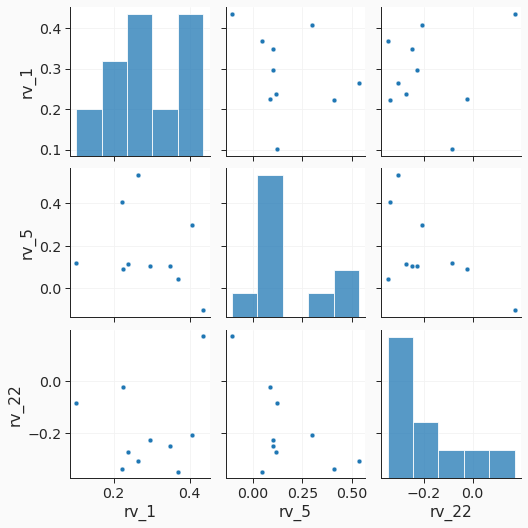

In [70]:
sns.pairplot(har_regs_df.query('date_group == "2019_H1"').set_index('ticker').iloc[:,:3])

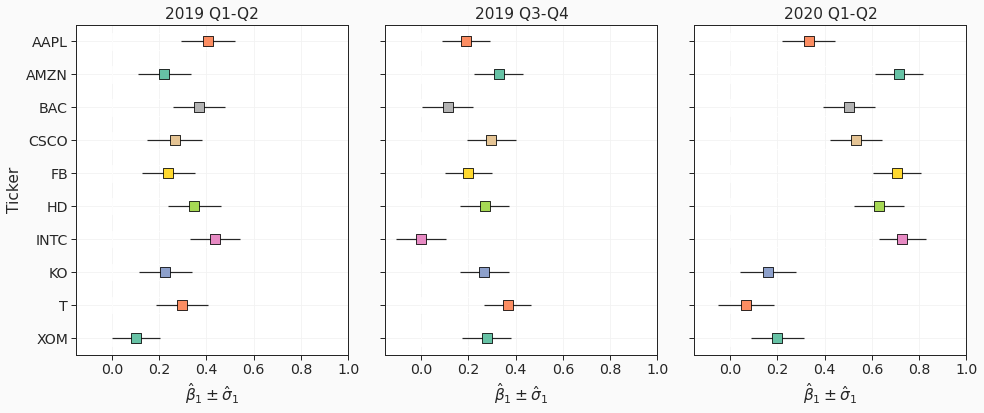

In [63]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)

har_regs_df["rv_1_95%"] = har_regs_df["rv_1_sd"] * 1.96

for i in range(3):

    dg = har_regs_df.reset_index()["date_group"].unique()[i]
    year = dg.split("_")[0]
    group = "Q1-Q2" if "H1" in dg else "Q3-Q4"
    ax = axs[i]

    plot_data_df = (
        har_regs_df.reset_index().query("date_group==@dg").sort_values(by="ticker", ascending=False)
    )

    # Error lines
    plot_data_df.plot(x="ticker", y="rv_1", kind="barh", color="none", xerr="rv_1_sd", ax=ax)
    # Point estimates
    sns.scatterplot(
        x="rv_1",
        y="index",
        data=plot_data_df.reset_index(drop=True).reset_index(),
        ax=ax,
        marker="s",
        s=100,
        hue="ticker",
        edgecolor="black",
        palette=sns.color_palette("Set2", 10),
        **{"zorder": 100},
    )

    ax.get_legend().remove()
    ax.set_title(f"{year} {group}")
    ax.set_xlim(-0.15, 1)
    ax.set_ylabel("Ticker")
    ax.set_xlabel("$\\hat{\\beta}_1 \\pm \\hat{\\sigma}_1$ ")

plt.tight_layout()
plt.savefig("../exhibits/beta_d_2019.pdf")

## Rolling Beta Estimates

In [88]:
# Window length
window = 22

# Pick a subset of stocks
ticker_subset = (
    data_har_df.reset_index()
    .merge(
        data_mcap_df.query("year == 2019").drop(["year"], axis=1),
        on="ticker",
        how="left",
    )
    .groupby("ticker")["mkvalt"]
    .first()
    .sort_values(ascending=False)
    .iloc[:10]
    .index
)


# Run HARs
results = []

for ticker in tqdm(ticker_subset):

    reg_df = data_har_df.query("ticker == @ticker")[
        ["date", "rv_lead", "rv_1", "rv_5", "rv_22"]
    ].dropna().set_index('date')
    fit = RollingOLS.from_formula("rv_lead ~ rv_1 + rv_5 + rv_22", reg_df, window).fit()
    
    

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker
    

    results.append(fit_params_df.reset_index())

# Format results
results_df = pd.concat(results)

In [89]:
rv_1_df.head()

,index,Intercept,beta_1,rv_5,rv_22,ticker
0,2019-02-01,NaN,NaN,NaN,NaN,AAPL
1,2019-02-04,NaN,NaN,NaN,NaN,AAPL
2,2019-02-05,NaN,NaN,NaN,NaN,AAPL
3,2019-02-06,NaN,NaN,NaN,NaN,AAPL
4,2019-02-07,NaN,NaN,NaN,NaN,AAPL


In [90]:
rv_1_df = results_df.rename(columns = {'date': 'index', 'rv_1': 'beta_1'})

In [113]:
(data_har_df.query('ticker == "AMZN" & date < "2020-03-02"')[
        ["date", "rv_lead", "rv_1", "rv_5", "rv_22"]
    ]).query('date >= "2020-02-11"').head(10)

,date,rv_lead,rv_1,rv_5,rv_22
14425,2020-02-11,0.000096,0.000307,0.000173,0.000104
14426,2020-02-12,0.000124,0.000096,0.000157,0.000105
14427,2020-02-13,0.000056,0.000124,0.000162,0.000109
14428,2020-02-14,0.000085,0.000056,0.000141,0.000108
14429,2020-02-18,0.000057,0.000085,0.000134,0.000109
14430,2020-02-19,0.000180,0.000057,0.000084,0.000109
14431,2020-02-20,0.000195,0.000180,0.000100,0.000116
14432,2020-02-21,0.000229,0.000195,0.000115,0.000122
14433,2020-02-24,0.000441,0.000229,0.000149,0.000128
14434,2020-02-25,0.000715,0.000441,0.000220,0.000146


In [118]:
rv_1_df.query('ticker == "AMZN"').query('index > "2020-02-25"').head(10)

,index,Intercept,beta_1,rv_5,rv_22,ticker
268,2020-03-02,-0.000542,1.390482,0.558223,4.582700,AMZN
269,2020-03-03,-0.000599,-0.529119,0.306074,8.541571,AMZN
270,2020-03-04,-0.000299,0.304415,-1.809278,7.106848,AMZN
271,2020-03-05,-0.000290,0.313241,-1.888620,7.192648,AMZN
272,2020-03-06,-0.000512,0.157646,-2.087812,9.784915,AMZN
273,2020-03-09,-0.000446,0.080595,-1.895369,9.023822,AMZN
274,2020-03-10,0.000019,0.096994,0.207728,1.756349,AMZN
275,2020-03-11,-0.000354,-0.095908,-1.166608,7.332983,AMZN
276,2020-03-12,-0.000389,-0.027330,-1.279502,7.615548,AMZN
277,2020-03-13,-0.000489,-0.066454,-0.918363,7.615530,AMZN


(18109.0, 18567.0)

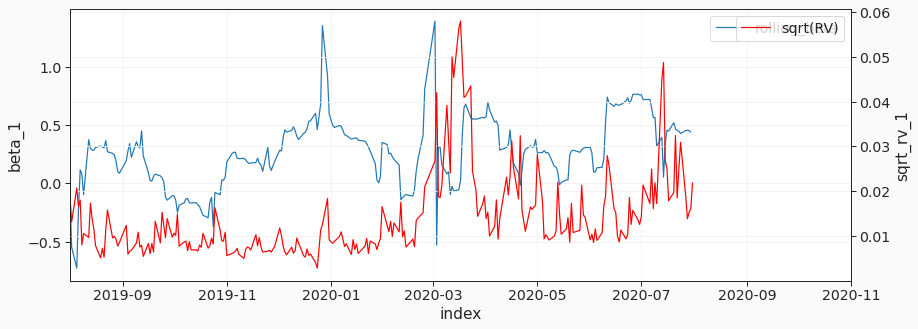

In [91]:
fig, ax = plt.subplots(figsize = (14,5))
sns.lineplot(x = 'index', y = 'beta_1', label = 'rolling_beta', data = rv_1_df.query('ticker == "AMZN"'), ax = ax)
ax_alt = ax.twinx()
data_har_df['sqrt_rv_1'] = np.sqrt(data_har_df['rv_1'])
sns.lineplot(x = 'date', y = 'sqrt_rv_1', label = 'sqrt(RV)',  color = 'red', data = data_har_df.query('ticker == "AMZN"').query('date > "2019/01/01"'), ax = ax_alt)
plt.xlim(pd.to_datetime('2019-08-01'), pd.to_datetime('2020-11-01'))


In [92]:
# data_df.query('ticker == "AAPL" & date == "2020-05-13"')['return_p2'].sum()

# data_har_df.query('ticker == "AAPL" & date <= "2020-05-13"').tail(66)['rv_1'].plot()

# rv_1_df.query('index == "2020-05-13"')

# smf.ols(
#     "rv_lead ~ rv_1 + rv_5  + rv_22",
#     data_har_df.query('ticker == "AAPL" & date <= "2020-05-13"').tail(44),
# ).fit().summary()

In [93]:
# Prices for each ticker
prices_df = data_df.groupby(['ticker', 'date'])['price'].last().reset_index()
prices_df = prices_df.query(f"ticker in @ticker_subset & date >= '{rv_1_df.dropna()['index'].min()}'").copy()
prices_df['first_price'] = prices_df.groupby('ticker')['price'].transform('first')
prices_df['price_idx'] = 100*prices_df['price']/prices_df['first_price']

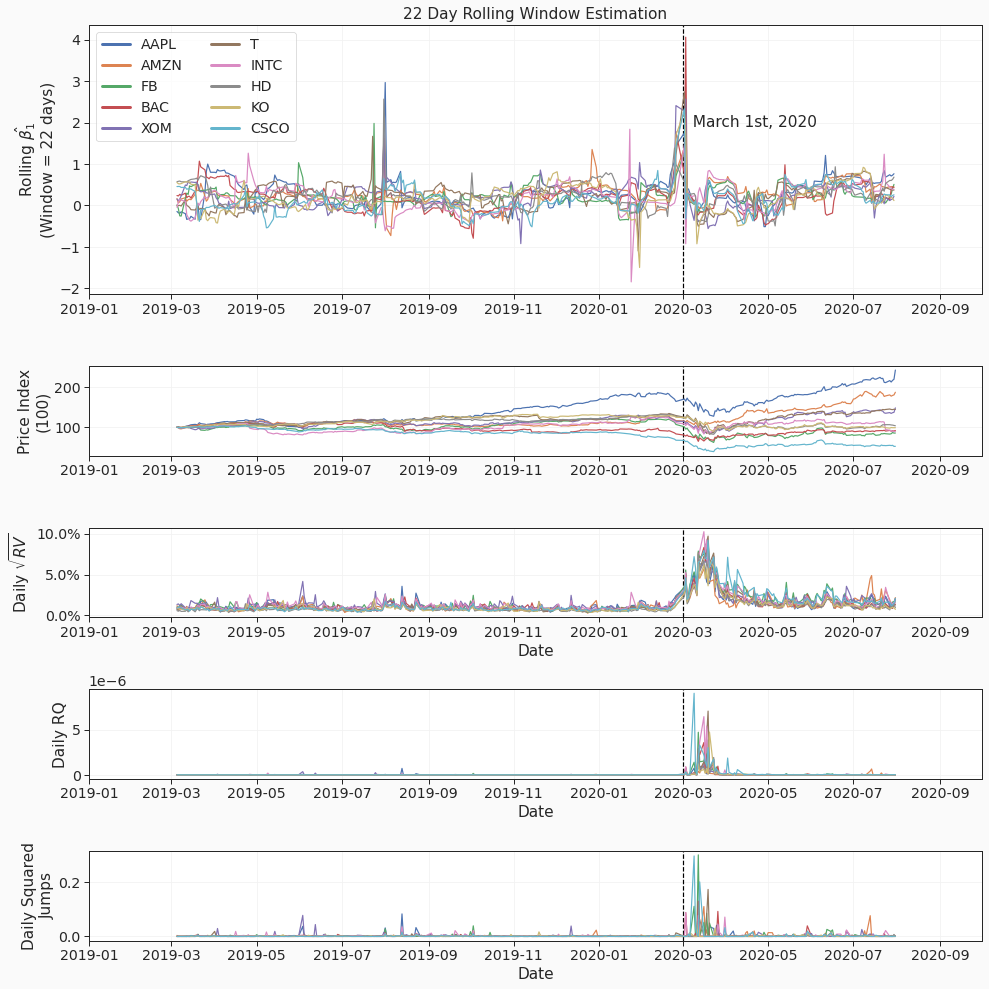

In [94]:
fig, axs = plt.subplots(figsize=(14, 14), nrows=5, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})

ax = axs[0]
ax.axvline(pd.to_datetime('2020-03-01'), 0, 1, ls = 'dashed', color = 'black')
sns.lineplot(
    x="index",
    y="beta_1",
    hue="ticker",
    palette=sns.color_palette("deep", 10),
    lw=1.2,
    data=rv_1_df,
    ax=ax,
)
ax.text(pd.to_datetime('03/01/2020'), 2, '  March 1st, 2020', va = 'center', ha = 'left')

ax.set_xlabel('')
ax.set_ylabel('Rolling $\\hat{\\beta_1}$\n(Window = ' + f'{window} days)')
ax.set_title(f'{window} Day Rolling Window Estimation')

ax.legend(ncol=2, loc = 'upper left')
leg = ax.get_legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

ax = axs[1]
ax.axvline(pd.to_datetime('2020-03-01'), 0, 1, ls = 'dashed', color = 'black')
sns.lineplot(
    x="date",
    y="price_idx",
    hue="ticker",
    palette=sns.color_palette("deep", 10),
    lw=1.2,
    data=prices_df,
    ax = ax
)
ax.set_xlabel('')
ax.set_ylabel('Price Index\n(100)')
ax.get_legend().remove()

# Realized Volatility
ax = axs[2]
ax.axvline(pd.to_datetime('2020-03-01'), 0, 1, ls = 'dashed', color = 'black')
data_har_df['rvol_1'] = np.sqrt(data_har_df['rv_1'])
sns.lineplot(
    x="date",
    y="rvol_1",
    hue="ticker",
    palette=sns.color_palette("deep", 10),
    lw=1.2,
    data=data_har_df.query(f"ticker in @ticker_subset & date >= '{rv_1_df.dropna()['index'].min()}'"),
    ax = ax
)
ax.set_xlabel('Date')
ax.set_ylabel('Daily $\\sqrt{RV}$')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Realized Quarticity
ax = axs[3]
ax.axvline(pd.to_datetime('2020-03-01'), 0, 1, ls = 'dashed', color = 'black')
data_har_df['rq_1'] = data_har_df['return_p4'] 
sns.lineplot(
    x="date",
    y="rq_1",
    hue="ticker",
    palette=sns.color_palette("deep", 10),
    lw=1.2,
    data=data_har_df.query(f"ticker in @ticker_subset & date >= '{rv_1_df.dropna()['index'].min()}'"),
    ax = ax
)
ax.set_xlabel('Date')
ax.set_ylabel('Daily RQ')
# ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Sum of Squared Jumps
ax = axs[4]
ax.axvline(pd.to_datetime('2020-03-01'), 0, 1, ls = 'dashed', color = 'black')
sns.lineplot(
    x="date",
    y="sum_jump_p2_1",
    hue="ticker",
    palette=sns.color_palette("deep", 10),
    lw=1.2,
    data=data_har_df.query(f"ticker in @ticker_subset & date >= '{rv_1_df.dropna()['index'].min()}'"),
    ax = ax
)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Squared\nJumps')
ax.get_legend().remove()

for ax in axs.reshape(-1):
    ax.set_xlim(pd.to_datetime('2019/01/01'), pd.to_datetime('2020/10/01'))

plt.tight_layout()
plt.savefig(f"../exhibits/beta_d_rolling_{window}.pdf")

# Regressions (Type 1)

In [239]:
fit1 = smf.ols(
    """rv_lead ~ rv_1 + 
        rv_5  +
        rv_22 
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_lead   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     75.35
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           1.68e-38
Time:                        16:38:16   Log-Likelihood:                 2603.6
No. Observations:                 396   AIC:                            -5199.
Df Residuals:                     392   BIC:                            -5183.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.628e-05   1.84e-05      2.515      0.012    1.02e-05    8.23e-05
rv_1           0.3445      0.080      4.331      0.000       0.189       0.500
rv_5           0.5690      0.107      5.296      0.000       0.358       0.780
rv_22         -0.1038      0.068     -1.522      0.128      -0.237       0.030
==============================================================================
Omnibus:                      473.582   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53649.633
Skew:                           5.321   Prob(JB):                         0.00
Kurtosis:                      59.020   Cond. No.                     6.27e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [240]:
fit2 = smf.ols(
    """rv_lead ~ rv_1 + rv_1:sum_jump_p2_1 + sum_jump_p2_1 + 
        rv_5 + rv_5:sum_jump_p2_5 + sum_jump_p2_5 +
        rv_22 + rv_22:sum_jump_p2_22 + sum_jump_p2_22
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_lead   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     93.00
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           5.22e-91
Time:                        16:38:20   Log-Likelihood:                 2626.9
No. Observations:                 396   AIC:                            -5234.
Df Residuals:                     386   BIC:                            -5194.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.301e-05   2.92e-05     -0.446      0.656   -7.02e-05    4.42e-05
rv_1                     0.1846      0.108      1.708      0.088      -0.027       0.396
rv_1:sum_jump_p2_1       2.8228      0.860      3.284      0.001       1.138       4.508
sum_jump_p2_1            0.0003      0.005      0.063      0.950      -0.009       0.010
rv_5                     0.9149      0.143      6.383      0.000       0.634       1.196
rv_5:sum_jump_p2_5     -12.2432      3.671     -3.335      0.001     -19.438      -5.048
sum_jump_p2_5           -0.0132      0.005     -2.702      0.007      -0.023      -0.004
rv_22                    0.2454      0.329      0.745      0.456      -0.400       0.891
rv_22:sum_jump_p2_22   -28.9267     25.166     -1.149      0.250     -78.252      20.399
sum_jump_p2_22           0.0018      0.009      0.205      0.837      -0.015       0.019
==============================================================================
Omnibus:                      411.115   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35295.063
Skew:                           4.221   Prob(JB):                         0.00
Kurtosis:                      48.473   Cond. No.                     1.17e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
[2] The condition number is large, 1.17e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [259]:
fit2a = smf.ols(
    """rv_lead ~ rv_1 + rv_1:sum_jump_p2_1  + 
        rv_5 + rv_5:sum_jump_p2_5  +
        rv_22 + rv_22:sum_jump_p2_22 
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})
fit2b = smf.ols(
    """rv_lead ~ rv_1 + sum_jump_p2_1  + 
        rv_5 + sum_jump_p2_5  +
        rv_22 + sum_jump_p2_22 
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})

In [292]:
stargazer = Stargazer([fit1, fit2a, fit2b, fit2])
stargazer.title('test')
stargazer_str = stargazer.render_latex()
stargazer_str = (
    stargazer_str.replace("rv_1", "$RV_t^{(d)}$")
    .replace("rv_5", "$RV_t^{(w)}$")
    .replace("rv_22", "$RV_t^{(m)}$")
)
stargazer_str = stargazer_str.replace(':', ' $ \\times \\;$ ')
stargazer_str = stargazer_str.replace('sum_jump_p2_1', '$\\overline{J^2}^{(d)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_5', '$\\overline{J^2}^{(w)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_22', '$\\overline{J^2}^{(m)}_t$')
print(stargazer_str)

\begin{table}[!htbp] \centering
  \caption{test}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable $ \times \;$ }} \
\cr \cline{4-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & 0.000$^{**}$ & -0.000$^{}$ & 0.000$^{**}$ & -0.000$^{}$ \\
  & (0.000) & (0.000) & (0.000) & (0.000) \\
 $RV_t^{(d)}$ & 0.344$^{***}$ & 0.193$^{*}$ & 0.231$^{**}$ & 0.185$^{*}$ \\
  & (0.080) & (0.103) & (0.108) & (0.108) \\
 $RV_t^{(d)}$ $ \times \;$ $\overline{J^2}^{(d)}_t$ & & 2.680$^{***}$ & & 2.823$^{***}$ \\
  & & (0.579) & & (0.860) \\
 $RV_t^{(m)}$ & -0.104$^{}$ & 0.341$^{}$ & -0.122$^{*}$ & 0.245$^{}$ \\
  & (0.068) & (0.289) & (0.072) & (0.329) \\
 $RV_t^{(m)}$ $ \times \;$ $\overline{J^2}^{(m)}_t$ & & -36.894$^{}$ & & -28.927$^{}$ \\
  & & (24.762) & & (25.166) \\
 $RV_t^{(w)}$ & 0.569$^{***}$ & 0.885$^{***}$ & 0.856$^{***}$ & 0.915$^{***}$ \\
  & (0.107) & (0.142) & (0.153) & (0.143) \\
 $RV_t^{(w)}$ 

In [302]:
fit3a = smf.ols(
    """rv_lead ~ rv_1 + rv_1:sum_jump_p2_pos_1 + rv_1:sum_jump_p2_neg_1 + 
        rv_5 + rv_5:sum_jump_p2_pos_5 + rv_5:sum_jump_p2_neg_5  + 
        rv_22 + rv_22:sum_jump_p2_pos_22 + rv_22:sum_jump_p2_neg_22  
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})
fit3a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_lead   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     116.0
Date:                Fri, 23 Oct 2020   Prob (F-statistic):          5.11e-104
Time:                        17:14:54   Log-Likelihood:                 2633.3
No. Observations:                 396   AIC:                            -5247.
Df Residuals:                     386   BIC:                            -5207.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2.307e-05   2.21e-05     -1.043      0.297   -6.64e-05    2.03e-05
rv_1                         0.1621      0.100      1.619      0.105      -0.034       0.358
rv_1:sum_jump_p2_pos_1       2.7204      0.549      4.952      0.000       1.644       3.797
rv_1:sum_jump_p2_neg_1      17.0190      4.941      3.445      0.001       7.336      26.702
rv_5                         0.9347      0.227      4.118      0.000       0.490       1.380
rv_5:sum_jump_p2_pos_5     -14.3339      3.749     -3.823      0.000     -21.682      -6.986
rv_5:sum_jump_p2_neg_5     -46.5072     10.848     -4.287      0.000     -67.768     -25.246
rv_22                        0.2140      0.202      1.057      0.290      -0.183       0.611
rv_22:sum_jump_p2_pos_22   -27.0770     38.664     -0.700      0.484    -102.858      48.704
rv_22:sum_jump_p2_neg_22   -11.6581     93.976     -0.124      0.901    -195.849     172.532
==============================================================================
Omnibus:                      428.591   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36542.538
Skew:                           4.552   Prob(JB):                         0.00
Kurtosis:                      49.172   Cond. No.                     4.71e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
[2] The smallest eigenvalue is 1.79e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [303]:
fit3b = smf.ols(
    """rv_lead ~ rv_1 + rv_1:sum_jump_p2_pos_1 + rv_1:sum_jump_p2_neg_1 + sum_jump_p2_1 + 
        rv_5 + rv_5:sum_jump_p2_pos_5 + rv_5:sum_jump_p2_neg_5 + sum_jump_p2_5 + 
        rv_22 + rv_22:sum_jump_p2_pos_22 + rv_22:sum_jump_p2_neg_22  + sum_jump_p2_22
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})
fit3b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_lead   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     123.4
Date:                Fri, 23 Oct 2020   Prob (F-statistic):          1.97e-123
Time:                        17:14:54   Log-Likelihood:                 2634.8
No. Observations:                 396   AIC:                            -5244.
Df Residuals:                     383   BIC:                            -5192.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.499e-07   2.36e-05      0.006      0.995   -4.61e-05    4.64e-05
rv_1                         0.1649      0.109      1.518      0.129      -0.048       0.378
rv_1:sum_jump_p2_pos_1       3.5475      0.897      3.955      0.000       1.790       5.305
rv_1:sum_jump_p2_neg_1      18.9039      4.950      3.819      0.000       9.201      28.606
sum_jump_p2_1               -0.0033      0.005     -0.658      0.510      -0.013       0.007
rv_5                         0.9536      0.216      4.420      0.000       0.531       1.376
rv_5:sum_jump_p2_pos_5     -12.4276      4.534     -2.741      0.006     -21.314      -3.541
rv_5:sum_jump_p2_neg_5     -44.1792     14.781     -2.989      0.003     -73.150     -15.209
sum_jump_p2_5               -0.0050      0.009     -0.547      0.584      -0.023       0.013
rv_22                        0.1477      0.216      0.683      0.494      -0.276       0.571
rv_22:sum_jump_p2_pos_22   -24.0532     37.417     -0.643      0.520     -97.388      49.282
rv_22:sum_jump_p2_neg_22    18.0455     94.967      0.190      0.849    -168.087     204.178
sum_jump_p2_22              -0.0087      0.016     -0.530      0.596      -0.041       0.024
==============================================================================
Omnibus:                      429.807   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36878.889
Skew:                           4.572   Prob(JB):                         0.00
Kurtosis:                      49.384   Cond. No.                     4.92e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
[2] The smallest eigenvalue is 1.64e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [304]:
fit3c = smf.ols(
    """rv_lead ~ rv_1 + rv_1:sum_jump_p2_pos_1 + rv_1:sum_jump_p2_neg_1 + sum_jump_p2_pos_1  + sum_jump_p2_neg_1 + 
        rv_5 + rv_5:sum_jump_p2_pos_5 + rv_5:sum_jump_p2_neg_5 + sum_jump_p2_pos_5  + sum_jump_p2_neg_5 + 
        rv_22 + rv_22:sum_jump_p2_pos_22 + rv_22:sum_jump_p2_neg_22  + sum_jump_p2_pos_22  + sum_jump_p2_neg_22
    """,
    data=data_har_df.query('ticker == "AAPL"'),
).fit(cov_type='HAC',cov_kwds={'maxlags':22})
fit3c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_lead   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     116.6
Date:                Fri, 23 Oct 2020   Prob (F-statistic):          7.43e-132
Time:                        17:14:55   Log-Likelihood:                 2635.6
No. Observations:                 396   AIC:                            -5239.
Df Residuals:                     380   BIC:                            -5176.
Df Model:                          15                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.695e-05   2.28e-05      0.742      0.458   -2.78e-05    6.17e-05
rv_1                         0.1581      0.111      1.427      0.153      -0.059       0.375
rv_1:sum_jump_p2_pos_1       3.7829      0.704      5.375      0.000       2.403       5.162
rv_1:sum_jump_p2_neg_1      14.6397      8.676      1.687      0.092      -2.365      31.644
sum_jump_p2_pos_1           -0.0047      0.003     -1.364      0.173      -0.011       0.002
sum_jump_p2_neg_1            0.0021      0.014      0.152      0.880      -0.025       0.030
rv_5                         1.0014      0.246      4.075      0.000       0.520       1.483
rv_5:sum_jump_p2_pos_5     -13.6221      5.404     -2.521      0.012     -24.214      -3.031
rv_5:sum_jump_p2_neg_5     -37.0871     10.871     -3.412      0.001     -58.394     -15.780
sum_jump_p2_pos_5           -0.0026      0.013     -0.202      0.840      -0.028       0.023
sum_jump_p2_neg_5           -0.0156      0.008     -1.930      0.054      -0.031       0.000
rv_22                        0.0521      0.221      0.236      0.813      -0.380       0.484
rv_22:sum_jump_p2_pos_22   -43.0898     59.815     -0.720      0.471    -160.325      74.146
rv_22:sum_jump_p2_neg_22    75.4157    154.205      0.489      0.625    -226.820     377.652
sum_jump_p2_pos_22           0.0114      0.018      0.634      0.526      -0.024       0.046
sum_jump_p2_neg_22          -0.0415      0.058     -0.714      0.475      -0.155       0.072
==============================================================================
Omnibus:                      426.224   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35682.229
Skew:                           4.515   Prob(JB):                         0.00
Kurtosis:                      48.618   Cond. No.                     6.13e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
[2] The smallest eigenvalue is 1.05e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [305]:
stargazer = Stargazer([fit3a, fit3b, fit3c])
stargazer.title('test')
stargazer_str = stargazer.render_latex()
stargazer_str = (
    stargazer_str.replace("rv_1", "$RV_t^{(d)}$")
    .replace("rv_5", "$RV_t^{(w)}$")
    .replace("rv_22", "$RV_t^{(m)}$")
)
stargazer_str = stargazer_str.replace(':', ' $ \\times \\;$ ')
stargazer_str = stargazer_str.replace('sum_jump_p2_1', '$\\overline{J^2}^{(d)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_5', '$\\overline{J^2}^{(w)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_22', '$\\overline{J^2}^{(m)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_pos_1', '$\\overline{J_+^2}^{(d)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_pos_5', '$\\overline{J_+^2}^{(w)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_pos_22', '$\\overline{J_+^2}^{(m)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_neg_1', '$\\overline{J_-^2}^{(d)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_neg_5', '$\\overline{J_-^2}^{(w)}_t$')
stargazer_str = stargazer_str.replace('sum_jump_p2_neg_22', '$\\overline{J_-^2}^{(m)}_t$')
print(stargazer_str)

\begin{table}[!htbp] \centering
  \caption{test}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable $ \times \;$ }} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & -0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ \\
  & (0.000) & (0.000) & (0.000) \\
 $RV_t^{(d)}$ & 0.162$^{}$ & 0.165$^{}$ & 0.158$^{}$ \\
  & (0.100) & (0.109) & (0.111) \\
 $RV_t^{(d)}$ $ \times \;$ $\overline{J_-^2}^{(d)}_t$ & 17.019$^{***}$ & 18.904$^{***}$ & 14.640$^{*}$ \\
  & (4.941) & (4.950) & (8.676) \\
 $RV_t^{(d)}$ $ \times \;$ $\overline{J_+^2}^{(d)}_t$ & 2.720$^{***}$ & 3.547$^{***}$ & 3.783$^{***}$ \\
  & (0.549) & (0.897) & (0.704) \\
 $RV_t^{(m)}$ & 0.214$^{}$ & 0.148$^{}$ & 0.052$^{}$ \\
  & (0.202) & (0.216) & (0.221) \\
 $RV_t^{(m)}$ $ \times \;$ $\overline{J_-^2}^{(m)}_t$ & -11.658$^{}$ & 18.045$^{}$ & 75.416$^{}$ \\
  & (93.976) & (94.967) & (154.205) \\
 $RV_t^{(m)}$ $ \times \;$ $\overline{J_+^2}^{(m)}_

# Regressions (Type 2)

## Time-Series Regressions

In [309]:
results = []

for ticker in tqdm(data_har_df["ticker"].unique()):

    ticker_fit = smf.ols(
        """rv_lead ~ rv_d_1 + rv_d_1:sum_jump_p2_1 + 
        rv_d_5 + rv_d_5:sum_jump_p2_5 +
        rv_d_22 + rv_d_22:sum_jump_p2_22
    """,
        data=data_har_df.query("ticker == @ticker"),
    ).fit()

    ticker_fit_params = dict(ticker_fit.params[1:])
    ticker_results = {**{"ticker": ticker}, **ticker_fit_params}

    results.append(ticker_results)

results_df = pd.DataFrame(results)

In [310]:
smf.ols(
        """rv_lead ~ rv_d_1 + rv_d_1:sum_jump_p2_1 + 
        rv_d_5 + rv_d_5:sum_jump_p2_5 +
        rv_d_22 + rv_d_22:sum_jump_p2_22
    """,
        data=data_har_df.query("ticker == 'AAPL'"),
    ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_lead   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     102.0
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           1.02e-76
Time:                        17:27:13   Log-Likelihood:                 2625.5
No. Observations:                 396   AIC:                            -5237.
Df Residuals:                     389   BIC:                            -5209.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.595e-05   2.96e-05     -0.539      0.590   -7.42e-05    4.23e-05
rv_d_1                     0.1833      0.072      2.536      0.012       0.041       0.325
rv_d_1:sum_jump_p2_1       4.1973      0.807      5.198      0.000       2.610       5.785
rv_d_5                     0.9014      0.134      6.734      0.000       0.638       1.165
rv_d_5:sum_jump_p2_5     -14.3759      3.895     -3.691      0.000     -22.034      -6.718
rv_d_22                    0.3055      0.268      1.142      0.254      -0.221       0.832
rv_d_22:sum_jump_p2_22   -33.9364     19.045     -1.782      0.076     -71.381       3.508
==============================================================================
Omnibus:                      407.913   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34574.148
Skew:                           4.168   Prob(JB):                         0.00
Kurtosis:                      48.010   Cond. No.                     1.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Beta_i for each stock

In [460]:
results = []
reg_data_df = data_har_df.query('year == 2019')

for ticker in tqdm(reg_data_df["ticker"].unique()):

    ticker_fit = smf.ols(
        """rv_lead ~ rv_1 + rv_5 + rv_22 
    """,
        data=reg_data_df.query("ticker == @ticker"),
    ).fit()

    ticker_fit_params = dict(ticker_fit.params[1:])
    ticker_results = {**{"ticker": ticker}, **ticker_fit_params}

    results.append(ticker_results)

results_df = pd.DataFrame(results)

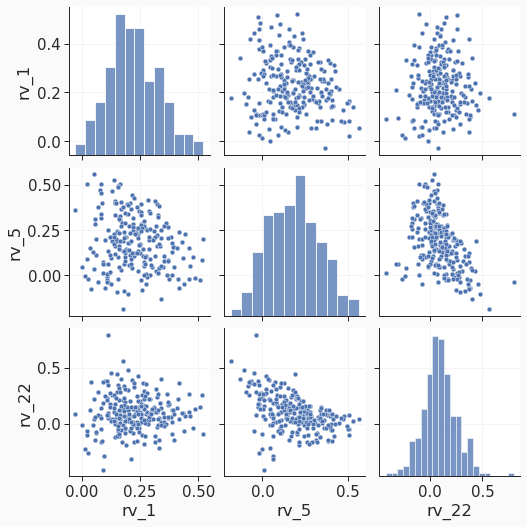

In [461]:
sns.pairplot(results_df.set_index('ticker').iloc[:,:3])

In [462]:
results_df = results_df.query('ticker != "GL"')

## Cross-sectional Regressions

In [452]:
# Melt dataframe and add average daily (sum J^2) for each ticker
results_melt_df = results_df.melt(id_vars="ticker", var_name="rvol_type", value_name="beta")
results_melt_df = results_melt_df.merge(
    data_har_df.query('year == 2019').groupby(["ticker"])
    .sum()
    .reset_index(),
    on="ticker",
    how="left",
)

results_melt_df = results_melt_df.merge(
    data_mcap_df.query("year == 2019").drop(["year"], axis=1), on="ticker", how="left"
)

results_melt_df.head()

,ticker,rvol_type,beta,return,return_p2,return_p4,return_lag1,return_bp,bipower_var_daily,bipower_var_tod,...,sum_jump_p2_22,sum_jump_p2_pos_1,sum_jump_p2_pos_5,sum_jump_p2_pos_22,sum_jump_p2_neg_1,sum_jump_p2_neg_5,sum_jump_p2_neg_22,quarter,year,mkvalt
0,A,rv_d_1,0.088244,0.127851,0.030434,6.275433e-07,0.082801,0.017779,1.402543,0.037260,...,0.210589,0.088060,0.087572,0.079805,0.137501,0.136592,0.130784,635,508788,23412.1283
1,AAL,rv_d_1,0.220704,-0.374921,0.079313,5.376305e-06,-0.416723,0.045697,3.602343,0.223207,...,0.483361,0.253811,0.252019,0.241967,0.237290,0.237290,0.241394,635,508788,12280.8620
2,AAP,rv_d_1,0.225094,0.107752,0.057075,2.038150e-06,0.091084,0.033846,2.664934,0.086566,...,0.387106,0.208864,0.208704,0.216370,0.136008,0.135617,0.170736,635,508788,11088.1971
3,AAPL,rv_d_1,0.478802,0.143991,0.030490,1.266624e-06,0.070916,0.017510,1.383513,0.035929,...,0.403747,0.191679,0.200384,0.207546,0.187252,0.192081,0.196200,635,508788,995151.5669
4,ABBV,rv_d_1,0.067307,0.063100,0.040116,1.273927e-06,0.042592,0.023146,1.826609,0.048569,...,0.296571,0.118708,0.118418,0.117571,0.184257,0.180629,0.179001,635,508788,130942.8685


In [455]:
results_melt_df['rvol_type'] = results_melt_df['rvol_type'].apply(lambda x: x.replace('_d', ''))

### Beta daily

In [456]:
fit1 = smf.ols("beta ~ return_j_p2", data=results_melt_df.query("rvol_type == 'rv_1'")).fit(
    cov_type="HC1"
)
fit2 = smf.ols(
    "beta ~ return_j_p2_pos + return_j_p2_neg", data=results_melt_df.query("rvol_type == 'rv_1'")
).fit(cov_type="HC1")

fit1m = smf.ols("beta ~ return_j_p2 + np.divide(mkvalt,1e9)", data=results_melt_df.query("rvol_type == 'rv_1'")).fit(
    cov_type="HC1"
)
fit2m = smf.ols(
    "beta ~ return_j_p2_pos + return_j_p2_neg + np.divide(mkvalt,1e9)", data=results_melt_df.query("rvol_type == 'rv_1'")
).fit(cov_type="HC1")

In [463]:
fit2m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beta   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     1.589
Date:                Fri, 23 Oct 2020   Prob (F-statistic):              0.192
Time:                        18:06:14   Log-Likelihood:                 125.08
No. Observations:                 275   AIC:                            -242.2
Df Residuals:                     271   BIC:                            -227.7
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1982      0.018     10.747      0.000       0.162       0.234
return_j_p2_pos          -19.7183     12.618     -1.563      0.118     -44.449       5.012
return_j_p2_neg           12.2391     14.143      0.865      0.387     -15.481      39.959
np.divide(mkvalt, 1e9)    60.6973     50.908      1.192      0.233     -39.080     160.475
==============================================================================
Omnibus:                        3.692   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.447
Skew:                           0.211   Prob(JB):                        0.178
Kurtosis:                       2.651   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [457]:
stargazer = Stargazer([fit1, fit2, fit1m, fit2m])
stargazer.title('testtitle')
stargazer_str = stargazer.render_latex()
stargazer_str = stargazer_str.replace(':', ' $ \\times \\;$ ')
stargazer_str = stargazer_str.replace('return_j_p2_pos', '$\\overline{J_+^2}$')
stargazer_str = stargazer_str.replace('return_j_p2_neg', '$\\overline{J_-^2}$')
stargazer_str = stargazer_str.replace('return_j_p2', '$\\overline{J^2}$')
stargazer_str = stargazer_str.replace('np.divide(mkvalt, 1e9)', 'MktCap (\\$B)')
display(stargazer)
print(stargazer_str)

\begin{table}[!htbp] \centering
  \caption{testtitle}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable $ \times \;$ }} \
\cr \cline{4-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & 0.286$^{***}$ & 0.286$^{***}$ & 0.268$^{***}$ & 0.268$^{***}$ \\
  & (0.013) & (0.013) & (0.013) & (0.013) \\
 MktCap (\$B) & & & 343.556$^{***}$ & 343.459$^{***}$ \\
  & & & (53.328) & (53.882) \\
 $\overline{J^2}$ & -8.131$^{**}$ & & -8.577$^{**}$ & \\
  & (3.883) & & (3.741) & \\
 $\overline{J_-^2}$ & & -8.873$^{}$ & & -8.424$^{}$ \\
  & & (8.429) & & (8.075) \\
 $\overline{J_+^2}$ & & -7.031$^{}$ & & -8.808$^{}$ \\
  & & (9.908) & & (9.362) \\
\hline \\[-1.8ex]
 Observations & 282 & 282 & 275 & 275 \\
 $R^2$ & 0.019 & 0.019 & 0.107 & 0.107 \\
 Adjusted $R^2$ & 0.016 & 0.012 & 0.100 & 0.097 \\
 Residual Std. Error & 0.118(df = 280) & 0.118(df = 279) & 0.113(df = 272) & 0.113(df = 271)  \\
 F Statistic & 4

### Beta weekly

In [458]:
fit1 = smf.ols("beta ~ return_j_p2", data=results_melt_df.query("rvol_type == 'rv_5'")).fit(
    cov_type="HC1"
)
fit2 = smf.ols(
    "beta ~ return_j_p2_pos + return_j_p2_neg", data=results_melt_df.query("rvol_type == 'rv_5'")
).fit(cov_type="HC1")

fit1m = smf.ols(
    "beta ~ return_j_p2 + np.divide(mkvalt,1e9)", data=results_melt_df.query("rvol_type == 'rv_5'")
).fit(cov_type="HC1")
fit2m = smf.ols(
    "beta ~ return_j_p2_pos + return_j_p2_neg + np.divide(mkvalt,1e9)",
    data=results_melt_df.query("rvol_type == 'rv_5'"),
).fit(cov_type="HC1")

stargazer = Stargazer([fit1, fit2, fit1m, fit2m])
stargazer.title('testtitle')
stargazer_str = stargazer.render_latex()
stargazer_str = stargazer_str.replace(':', ' $ \\times \\;$ ')
stargazer_str = stargazer_str.replace('return_j_p2_pos', '$\\overline{J_+^2}$')
stargazer_str = stargazer_str.replace('return_j_p2_neg', '$\\overline{J_-^2}$')
stargazer_str = stargazer_str.replace('return_j_p2', '$\\overline{J^2}$')
stargazer_str = stargazer_str.replace('np.divide(mkvalt, 1e9)', 'MktCap (\\$B)')
display(stargazer)
print(stargazer_str)

\begin{table}[!htbp] \centering
  \caption{testtitle}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable $ \times \;$ }} \
\cr \cline{4-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & 0.200$^{***}$ & 0.205$^{***}$ & 0.192$^{***}$ & 0.198$^{***}$ \\
  & (0.022) & (0.018) & (0.022) & (0.018) \\
 MktCap (\$B) & & & 68.729$^{}$ & 60.697$^{}$ \\
  & & & (50.408) & (50.908) \\
 $\overline{J^2}$ & -1.509$^{}$ & & -0.504$^{}$ & \\
  & (6.905) & & (6.860) & \\
 $\overline{J_-^2}$ & & 11.606$^{}$ & & 12.239$^{}$ \\
  & & (14.263) & & (14.143) \\
 $\overline{J_+^2}$ & & -20.935$^{}$ & & -19.718$^{}$ \\
  & & (12.910) & & (12.618) \\
\hline \\[-1.8ex]
 Observations & 282 & 282 & 275 & 275 \\
 $R^2$ & 0.000 & 0.008 & 0.002 & 0.010 \\
 Adjusted $R^2$ & -0.003 & 0.001 & -0.005 & -0.001 \\
 Residual Std. Error & 0.156(df = 280) & 0.156(df = 279) & 0.155(df = 272) & 0.155(df = 271)  \\
 F Statistic & 0.04

### Beta monthly

In [459]:
fit1 = smf.ols("beta ~ return_j_p2", data=results_melt_df.query("rvol_type == 'rv_22'")).fit(
    cov_type="HC1"
)
fit2 = smf.ols(
    "beta ~ return_j_p2_pos + return_j_p2_neg", data=results_melt_df.query("rvol_type == 'rv_22'")
).fit(cov_type="HC1")

fit1m = smf.ols(
    "beta ~ return_j_p2 + np.divide(mkvalt,1e9)", data=results_melt_df.query("rvol_type == 'rv_22'")
).fit(cov_type="HC1")
fit2m = smf.ols(
    "beta ~ return_j_p2_pos + return_j_p2_neg + np.divide(mkvalt,1e9)",
    data=results_melt_df.query("rvol_type == 'rv_5'"),
).fit(cov_type="HC1")

stargazer = Stargazer([fit1, fit2, fit1m, fit2m])
stargazer.title('testtitle')
stargazer_str = stargazer.render_latex()
stargazer_str = stargazer_str.replace(':', ' $ \\times \\;$ ')
stargazer_str = stargazer_str.replace('return_j_p2_pos', '$\\overline{J_+^2}$')
stargazer_str = stargazer_str.replace('return_j_p2_neg', '$\\overline{J_-^2}$')
stargazer_str = stargazer_str.replace('return_j_p2', '$\\overline{J^2}$')
stargazer_str = stargazer_str.replace('np.divide(mkvalt, 1e9)', 'MktCap (\\$B)')
display(stargazer)
print(stargazer_str)

\begin{table}[!htbp] \centering
  \caption{testtitle}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable $ \times \;$ }} \
\cr \cline{4-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & 0.131$^{***}$ & 0.130$^{***}$ & 0.137$^{***}$ & 0.198$^{***}$ \\
  & (0.020) & (0.020) & (0.021) & (0.018) \\
 MktCap (\$B) & & & -49.952$^{}$ & 60.697$^{}$ \\
  & & & (51.337) & (50.908) \\
 $\overline{J^2}$ & -9.662$^{}$ & & -10.812$^{}$ & \\
  & (6.618) & & (6.682) & \\
 $\overline{J_-^2}$ & & -11.426$^{}$ & & 12.239$^{}$ \\
  & & (16.357) & & (14.143) \\
 $\overline{J_+^2}$ & & -7.049$^{}$ & & -19.718$^{}$ \\
  & & (21.528) & & (12.618) \\
\hline \\[-1.8ex]
 Observations & 282 & 282 & 275 & 275 \\
 $R^2$ & 0.012 & 0.012 & 0.016 & 0.010 \\
 Adjusted $R^2$ & 0.008 & 0.005 & 0.008 & -0.001 \\
 Residual Std. Error & 0.181(df = 280) & 0.181(df = 279) & 0.179(df = 272) & 0.155(df = 271)  \\
 F Statistic & 2.13